# 03. Intelligent Scissor Inference Demo
This notebook demonstrates the hybrid pipeline: U-Net for semantic initialization + GrabCut for edge refinement.

In [1]:
import sys
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2

sys.path.append('../src')
from model import UNet
from utils import prob_to_grabcut_mask, visualize, denormalize

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Load Model
MODEL_PATH = 'unet_coco_epoch_5.pth' # Point to your best model
model = UNet(n_channels=3, n_classes=1).to(DEVICE)

if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH))
    print("Model loaded successfully.")
else:
    print("WARNING: Model path not found. Initializing random model for demo.")

model.eval()

Model loaded successfully.


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [3]:
def intelligent_scissor(image_path, model, device):
    # 1. Load Original Image
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        raise ValueError(f"Image not found: {image_path}")
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    h, w = image_rgb.shape[:2]

    # 2. Preprocess for U-Net (512x512)
    transform = A.Compose([
        A.Resize(512, 512),
        A.Normalize(),
        ToTensorV2()
    ])
    augmented = transform(image=image_rgb)
    input_tensor = augmented['image'].unsqueeze(0).to(device)

    # 3. U-Net Inference
    with torch.no_grad():
        logits = model(input_tensor) # (1, 1, 512, 512)
        prob_map = torch.sigmoid(logits) # Apply sigmoid to logits
        prob_map = prob_map.squeeze().cpu().numpy()

    # 4. Resize Probability Map back to Original Size
    # Using linear interpolation for smoothness
    prob_map_full = cv2.resize(prob_map, (w, h), interpolation=cv2.INTER_LINEAR)

    # 5. Heuristic Mapping -> GrabCut Mask
    # High confidence -> Sure FG/BG. Low confidence -> Probable FG.
    gc_mask = prob_to_grabcut_mask(prob_map_full, low_thresh=0.1, high_thresh=0.9)

    # 6. GrabCut Refinement
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    
    # Run GrabCut (this modifies gc_mask in place)
    # Iterations = 5
    cv2.grabCut(image_bgr, gc_mask, None, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_MASK)
    
    # 7. Final Binary Mask
    # GC_FGD(1) and GC_PR_FGD(3) are Foreground
    final_mask = np.where((gc_mask == 2) | (gc_mask == 0), 0, 1).astype('uint8')
    
    return image_rgb, prob_map_full, gc_mask, final_mask

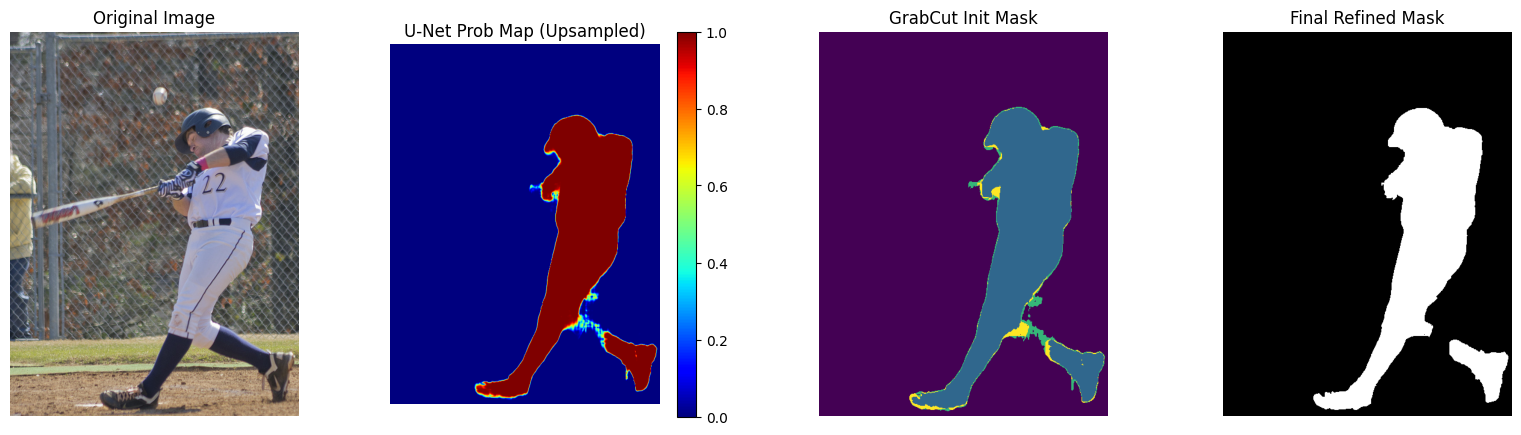

In [6]:
# Run Demo
IMAGE_PATH = '../data/coco2017/test2017/000000000016.jpg' # Replace with valid COCO image

if os.path.exists(IMAGE_PATH):
    image, prob_map, gc_mask, final_mask = intelligent_scissor(IMAGE_PATH, model, DEVICE)
    
    # Visualize
    # We use a custom plot here to show 4 stages
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 4, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.title("U-Net Prob Map (Upsampled)")
    plt.imshow(prob_map, cmap='jet')
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.title("GrabCut Init Mask")
    plt.imshow(gc_mask, vmin=0, vmax=3, cmap='viridis')
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.title("Final Refined Mask")
    plt.imshow(final_mask, cmap='gray')
    plt.axis('off')
    
    plt.show()
else:
    print("Please provide a valid image path to test.")